# Part 1

## Imports & Data Preparation

In [39]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import ast
import plotly.express as px
import mpld3

# Color codes to use : 
#95a3c3
#e99675
#72b6a1
#db96c0

In [4]:
#Import data
folder = "generated/"
df_movies=pd.read_csv(folder + "USE_THIS_DATASET.csv", index_col = 'Wikipedia movie ID')

#Add a column that has the decades
df_movies['decade'] = (df_movies['Movie release year'] // 10) * 10

#Add a column that has the seasons
def month_to_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"
df_movies['season'] = df_movies['Movie release month'].apply(month_to_season)

#Add a column that has the release days
df_movies['Movie release date'] = pd.to_datetime(df_movies['Movie release date'], errors='coerce')
df_movies['Movie release day'] = df_movies['Movie release date'].dt.day

df_movies.sample(1)

,Movie name,Movie release month,Movie release year,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary,Sentiment,Compound Score,Theme,vote_average,budget,decade,season,Movie release day
Wikipedia movie ID,,,,,,,,,,,,,,,,,,
4461403,"Hey, Hey, It's Esther Blueburger",3.0,2008.0,2008-03-20,NaN,103.0,['English'],"['Australia', 'New Zealand']","['Indie', 'World cinema', 'Coming of age', 'Co...",Esther Blueburger is a 13-year-old Jewish outc...,positive,0.9244,Belonging,NaN,NaN,2000.0,Spring,20.0


In [5]:
#Check how many NaN's in each column
df_movies.isna().sum()

Movie name                      0
Movie release month         21171
Movie release year           6834
Movie release date          21171
Movie box office revenue    70535
Movie runtime               20379
Movie languages                 0
Movie countries                 0
Movie genres                    0
Summary                     19378
Sentiment                   19378
Compound Score              19378
Theme                       19605
vote_average                39682
budget                      73232
decade                       6834
season                      21171
Movie release day           21171
dtype: int64

## Data Selection

In [7]:
#Filter df to only keep USA movies and non-nan rows in budget, release year and runtime
df_filtered = df_movies.dropna(subset=['budget', 'Movie box office revenue','Movie release year','Movie runtime'])
df_filtered = df_filtered[df_filtered['Movie countries'].apply(lambda x: 'United States of America' in x)]

#Add profitability metric (box office / budget)
df_filtered['profitability'] = df_filtered['Movie box office revenue']/df_filtered['budget']

#Remove big outliers for better visualization and generalization and small/no budget movies
df_filtered = df_filtered[df_filtered['profitability'] < 15]
df_filtered = df_filtered[df_filtered['budget'] > 10000] 

#Get 1 genre per row
df_filtered['Movie genres'] = df_filtered['Movie genres'].apply(ast.literal_eval)
df_exploded = df_filtered.explode('Movie genres')


In [8]:
#create df with 1 genre per row and filter to keep only USA movies
df_movies['Movie genres'] = df_movies['Movie genres'].apply(ast.literal_eval)

df_genres = df_movies.explode('Movie genres')
df_genres = df_genres.dropna(subset=['Movie release year','Movie runtime','Movie genres'])
df_genres = df_genres[df_genres['Movie countries'].apply(lambda x: 'United States of America' in x)]

In [9]:
#df with all non NaN release times
df_release = df_movies.dropna(subset=['Movie release year','Movie runtime'])
df_release = df_release[df_release['Movie countries'].apply(lambda x: 'United States of America' in x)]

In [10]:
#Number of movies remaining for our study 
print(df_filtered.shape)
print(df_genres.shape)

(4683, 19)
(115075, 18)


In [11]:
#Get the top 10 themes
top_10_themes = df_filtered['Theme'].value_counts().sort_values(ascending=False).head(15)
#print(top_10_themes)

#Define the 6 genres we will study, regrouping all related genres
family_genres = ["Children's/Family",'Family Film','Family-Oriented Adventure','Family Drama','Family & Personal Relationships',"Children's"]
war_genres = ['War film', 'Combat films', 'Anti-War film', 'Gulf War', 'Cold War', 'Nuclear warfare', 'War effort', 'Anti-war']
romantic_genres = ['Romantic thriller','Romantic fantasy','Romantic drama','Romantic comedy']
lgbt_genres = ['LGBT', 'Gay Interest', 'New Queer Cinema', 'Gay Themed', 'Queer Cinema','Gender Issues','Gay']
action_genres = ['Action','Action/Adventure','Action Thrillers','Action Comedy']
hero_genres = ['Superhero', 'Superhero movie']

#List of genres we will study
genres_list = ['Family','War','Romantic','LGBT','Action','Superhero']

In [12]:
#Rename the movie genres related to the general genres we will study
df_exploded['Movie genres'] = df_exploded['Movie genres'].replace(family_genres, 'Family') #1048
df_exploded['Movie genres'] = df_exploded['Movie genres'].replace(war_genres, 'War') #250
df_exploded['Movie genres'] = df_exploded['Movie genres'].replace(romantic_genres, 'Romantic') #908
df_exploded['Movie genres'] = df_exploded['Movie genres'].replace(lgbt_genres, 'LGBT') #233
df_exploded['Movie genres'] = df_exploded['Movie genres'].replace(action_genres, 'Action') #2396
df_exploded['Movie genres'] = df_exploded['Movie genres'].replace(hero_genres, 'Superhero') #149



In [13]:
#Check sample sizes
df_exploded[df_exploded['Movie genres'] == 'Family'].shape

(1048, 19)

## Does the analysis matter?


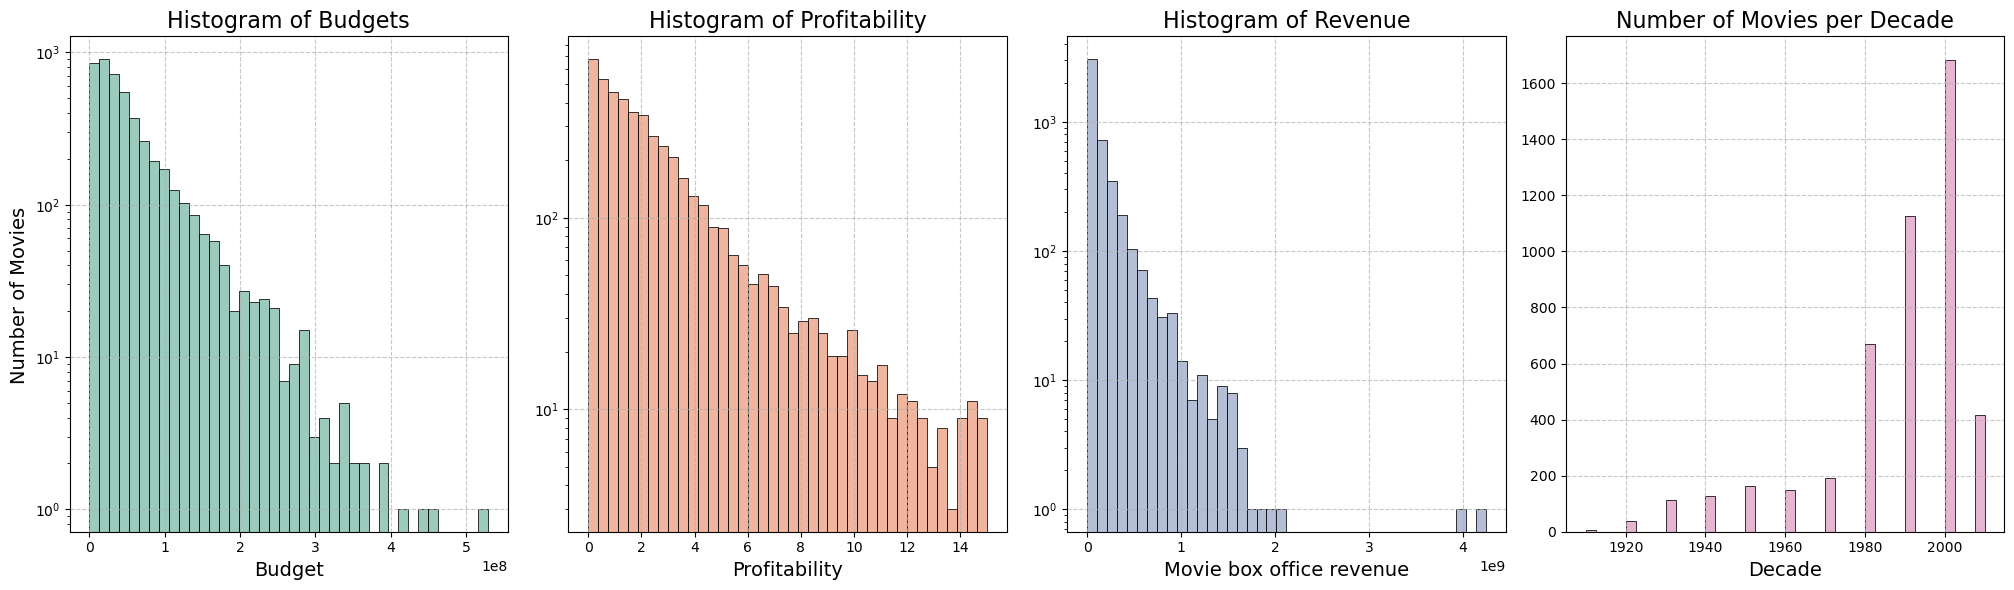

In [65]:
#plot histogram of budgets, profitability, revenue and number of movies per decade

#Create figure
fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=False)

#Define info and data of interest for our 4 plots 
variables = ['budget', 'profitability', 'Movie box office revenue', 'decade']
titles = ["Histogram of Budgets", "Histogram of Profitability", "Histogram of Revenue", "Number of Movies per Decade"]
colors = ['#72b6a1', '#e99675', '#95a3c3', '#db96c0']

#Plot all 4 histograms with a loop
for i, (ax, var, title, color) in enumerate(zip(axes, variables, titles, colors)):
    sns.histplot(data=df_filtered, x=var, bins=40, kde=False, color=color, alpha=0.7, ax=ax)
    
    if i < 3:  # Set y-axis to log scale for plots 1, 2 and 3
        ax.set_yscale('log')
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(var.capitalize(), fontsize=14)
    ax.set_ylabel("", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    
fig.text(0.0, 0.5, 'Number of Movies', ha='center', va='center', rotation='vertical', fontsize=14)
plt.tight_layout()
plt.show()

#Distribution not normal -> we prefer using the median values rather than mean in the following graphs

# Save the plot as an HTML file
mpld3.save_html(fig, 'plot_1.html')

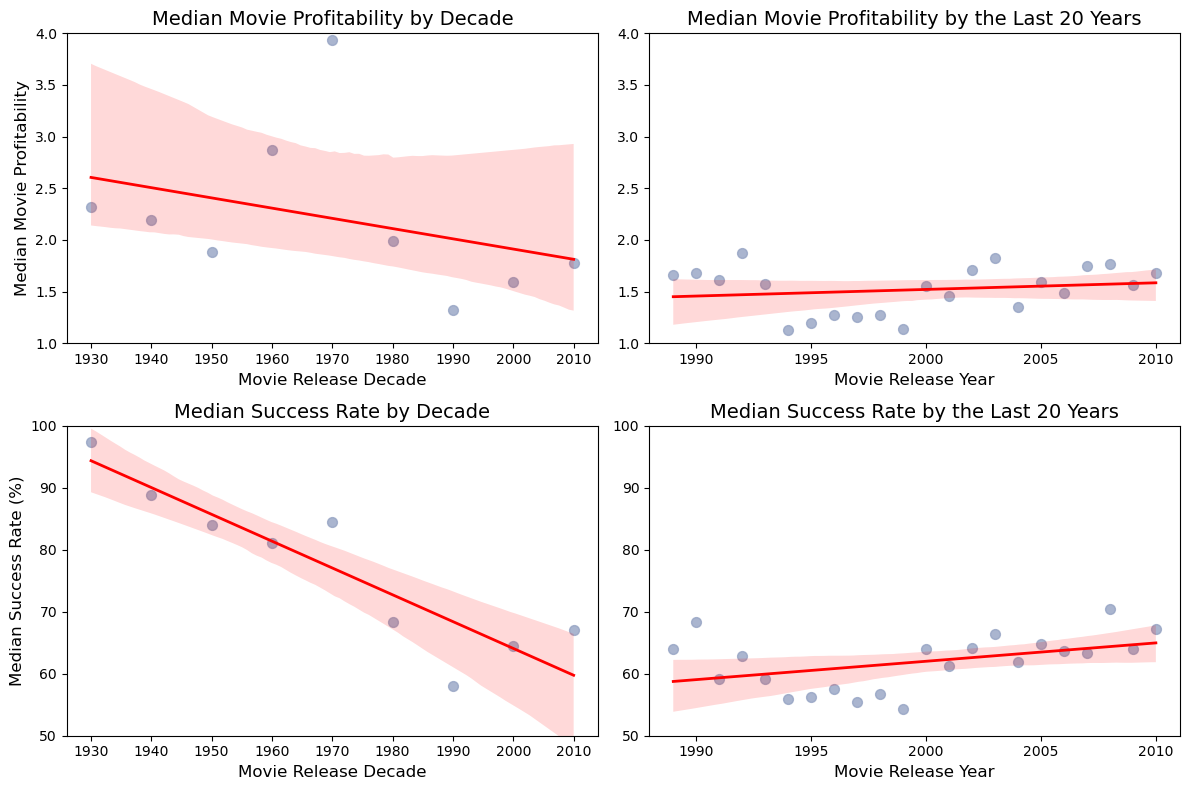

In [43]:
#Regression plot with scatter points and 95% confidence interval representing how the movie profitability evolved over time, and how the percentage of 
# profitable movies changed over time, for the last 100 and 20 years. 


#Add the movie success rate to the dataframe (100 if movie turned a profit, else 0)
df_filtered['success rate'] = np.where(df_filtered['profitability'] > 1, 100, 0)

#Filtering profitability data by decade, as very few data from 100 years ago it gives more samples to compute a meaningful medians/means. 
#profitability data
df_profitability_decade = df_filtered.copy()
df_profitability_decade = df_profitability_decade[df_profitability_decade['profitability'] < 15]
df_profitability_decade = df_profitability_decade[df_profitability_decade['decade'] > 1920]

median_profitability_per_decade = df_profitability_decade.groupby('decade')['profitability'].median().reset_index()

#success rate data
df_rate_decade = df_filtered.copy()
df_rate_decade = df_rate_decade[df_rate_decade['decade'] > 1920] 

median_rate_by_decade = df_rate_decade.groupby('decade')['success rate'].mean().reset_index()

#To observe the more recent evolution, we compute the medians per year for the last 20 years
#profitability data
df_profitability_year = df_filtered.copy()
df_profitability_year = df_profitability_year[df_profitability_year['Movie release year'] > 1988]
df_profitability_year = df_profitability_year[df_profitability_year['Movie release year'] < 2011]

median_profitability_per_year = df_profitability_year.groupby('Movie release year')['profitability'].median().reset_index()

#success rate data
df_rate_year = df_filtered.copy()
df_rate_year = df_rate_year[df_rate_year['Movie release year'] > 1988] 
df_rate_year = df_rate_year[df_rate_year['Movie release year'] < 2011] 

median_rate_by_year = df_rate_year.groupby('Movie release year')['success rate'].mean().reset_index()


#Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=False)

#Plot 1: Median Movie Profitability by Decade
sns.regplot(x=median_profitability_per_decade['decade'], y=median_profitability_per_decade['profitability'], ax=axes[0, 0],
            color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[0, 0].set_title("Median Movie Profitability by Decade", fontsize=14)
axes[0, 0].set_xlabel("Movie Release Decade", fontsize=12)
axes[0, 0].set_ylabel("Median Movie Profitability", fontsize=12)
axes[0, 0].set_ylim(1, 4)

#Plot 2: Median Movie Profitability by Year
sns.regplot(x=median_profitability_per_year['Movie release year'], y=median_profitability_per_year['profitability'], ax=axes[0, 1],
            color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[0, 1].set_title("Median Movie Profitability by the Last 20 Years", fontsize=14)
axes[0, 1].set_xlabel("Movie Release Year", fontsize=12)
axes[0, 1].set_ylabel("")
axes[0, 1].set_ylim(1, 4)

#Plot 3: Average Success Rate by Decade
sns.regplot(x=median_rate_by_decade['decade'], y=median_rate_by_decade['success rate'], ax=axes[1, 0],
            color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[1, 0].set_title("Median Success Rate by Decade", fontsize=14)
axes[1, 0].set_xlabel("Movie Release Decade", fontsize=12)
axes[1, 0].set_ylabel("Median Success Rate (%)", fontsize=12)
axes[1, 0].set_ylim(50, 100)

#Plot 4: Average Success Rate by Year
sns.regplot(x=median_rate_by_year['Movie release year'], y=median_rate_by_year['success rate'], ax=axes[1, 1],
            color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[1, 1].set_title("Median Success Rate by the Last 20 Years", fontsize=14)
axes[1, 1].set_xlabel("Movie Release Year", fontsize=12)
axes[1, 1].set_ylabel("")
axes[1, 1].set_ylim(50, 100)

plt.tight_layout()
plt.show()
mpld3.save_html(fig, 'plot_2.html')

## How did movie release period change with time?

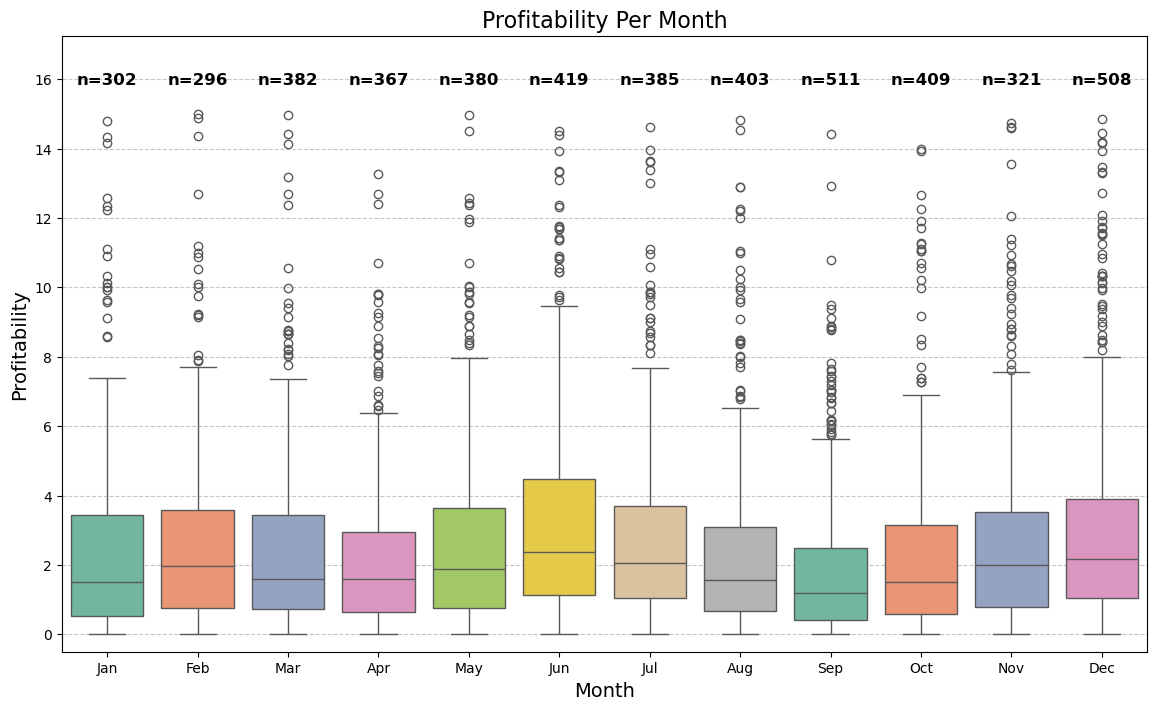

In [45]:
#Boxplot of profitability per month (independent from release year)

#plot
plt.figure(figsize=(14, 8))

sns.boxplot(x="Movie release month",y="profitability",data=df_filtered,legend = False,hue = "Movie release month",palette="Set2")

plt.title("Profitability Per Month", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Profitability", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

#Add number of samples per month
counts = df_filtered['Movie release month'].value_counts().sort_index()
ax = plt.gca()  
y_max = df_filtered['profitability'].max()
y_min = df_filtered['profitability'].min()
y_range = y_max - y_min

for i, decade in enumerate(sorted(counts.index)):
    count = counts[decade]
    ax.text(i, y_max + 0.05 * y_range,  f'n={count}', ha='center', va='bottom',fontsize=12,fontweight='bold')

plt.ylim(y_min-0.5, y_max + 0.15 * y_range)

#Change the numerical x labels to their corresponding month
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(ticks=np.linspace(0,11,12), labels=month_names)

plt.show()

mpld3.save_html(fig, 'plot_3.html')

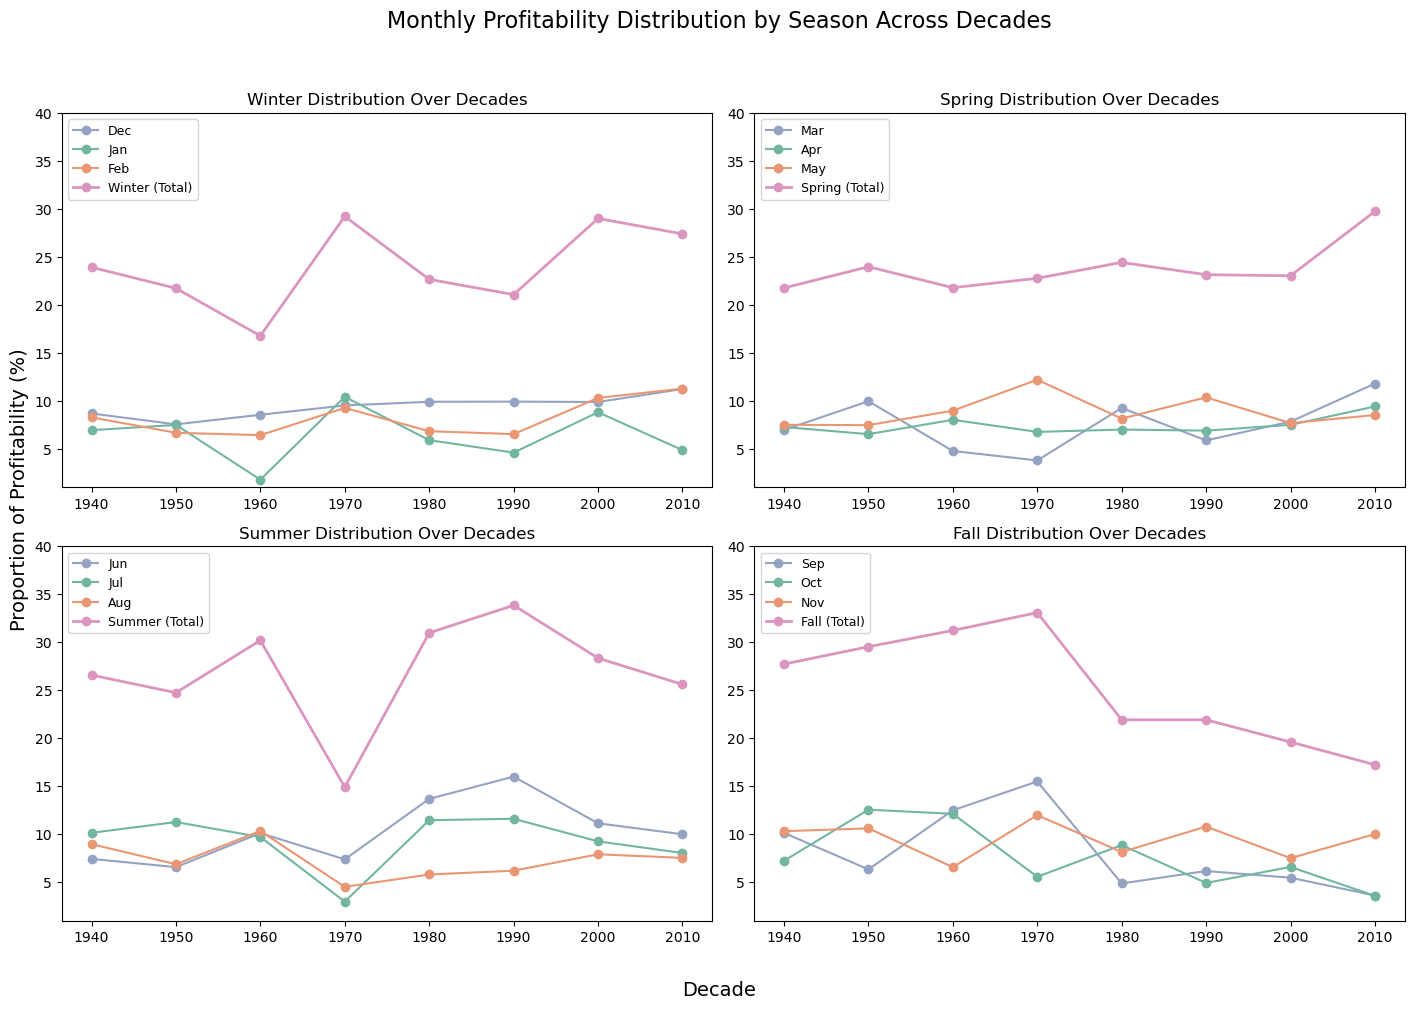

In [47]:
#Line plot showing the proportion of profitability achieved each month for a given decade, grouped by season to observe trends over time.

#preparation of the data : table that for each decade and month, gives the median profitability
df_data = df_filtered[df_filtered['decade']>1930]
data = df_data.pivot_table(index="decade", columns="Movie release month", values="profitability", aggfunc="median").fillna(0)

#Make the data proportional per month, to see how much a given month contributes to the total profitability of a given decade
data_proportional = data.div(data.sum(axis=1), axis=0)*100
counts = df_data['decade'].value_counts().sort_index()

#Names and colors for the line plots
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
seasons = {"Winter": [12, 1, 2], "Spring": [3, 4, 5], "Summer": [6, 7, 8], "Fall": [9, 10, 11]}
colors = ['#72b6a1', '#e99675', '#95a3c3','#72b6a1', '#e99675', '#95a3c3','#72b6a1', '#e99675', '#95a3c3','#72b6a1', '#e99675', '#95a3c3']

#Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=False, sharey=False)
axes = axes.flatten()

for i, (season_name, months) in enumerate(seasons.items()):
    ax = axes[i]

    #Plot months
    for month in months:
        ax.plot(data_proportional.index, data_proportional[month], label=month_names[month-1], marker="o", color=colors[month-1])

    #Plot seasons
    season_sum = data_proportional[months].sum(axis=1)
    ax.plot(data_proportional.index, season_sum, label=f"{season_name} (Total)", color="#db96c0", linewidth=2, linestyle="-", marker="o")

    ax.set_title(f"{season_name} Distribution Over Decades", fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(loc="upper left", fontsize=9)
    ax.set_ylim(1, 40)

fig.text(0.0, 0.5, 'Proportion of Profitability (%)', ha='center', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 0, 'Decade', ha='center', va='center', rotation='horizontal', fontsize=14)

fig.suptitle("Monthly Profitability Distribution by Season Across Decades", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

mpld3.save_html(fig, 'plot_4.html')

## Link to our genres

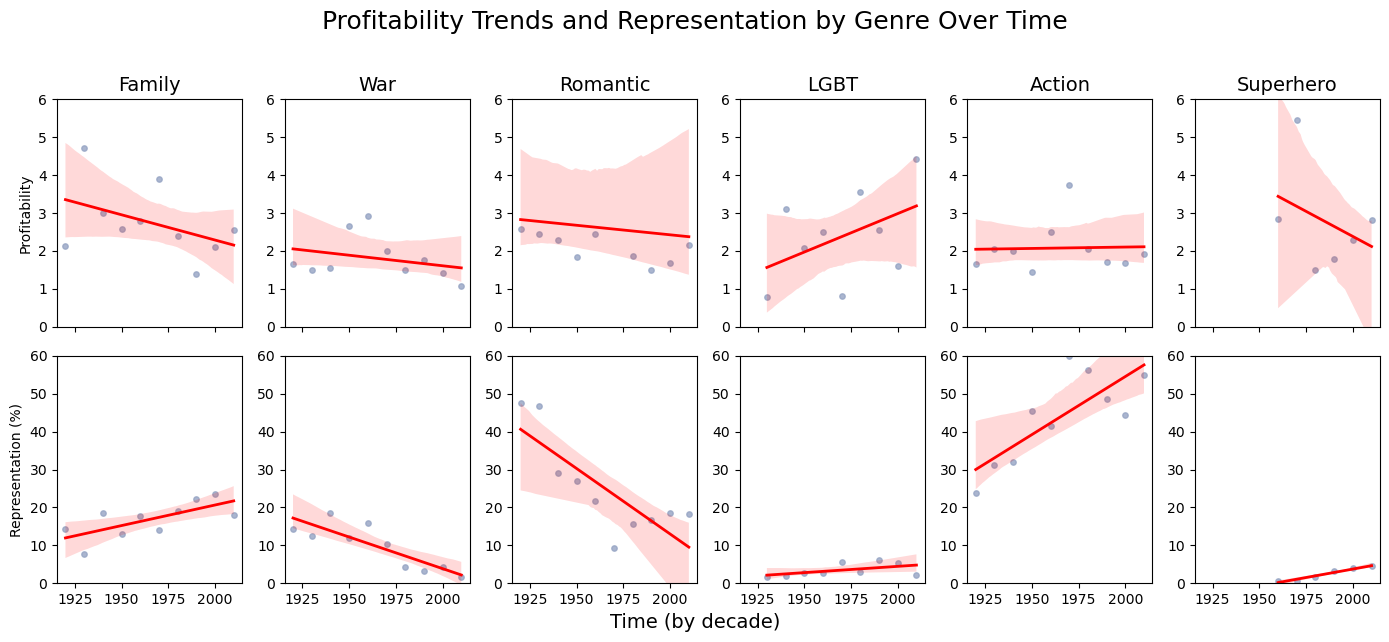

In [49]:
# Regression and scatterplot with 95% confidence interval which show how profitability evolved over time, and how representation of movie genres 
# evolved over time for the last 100 years. 

#Plot grid creation
n_rows, n_cols = 2, 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6), sharex=True, sharey=False)
axes = axes.flatten()

#Row 1 : profitability evolution over time for each studied genre
#Preparing data, keeping only data related to our genres and take the median profitability for each decade
df_genres_decade = df_exploded.groupby(['decade', 'Movie genres'])['profitability'].median().reset_index()
df_genres_decade = df_genres_decade[df_genres_decade['Movie genres'].isin(genres_list)].reset_index(drop=True)
df_genres_decade = df_genres_decade[df_genres_decade['decade'] > 1919]

#Plots with regression line and 95% confidence interval to observe trend
for i, theme in enumerate(genres_list):
    ax = axes[i]  
    theme_data = df_genres_decade[df_genres_decade['Movie genres'] == theme]
    sns.regplot(x='decade', y='profitability', data=theme_data, ax=ax, color='#95a3c3', scatter_kws={'s': 15}, 
                line_kws={'color': 'red', 'linewidth': 2})
    ax.set_title(f"{theme}", fontsize=14)
    ax.set_ylim(0, 6)
    ax.set_xlabel("")
    ax.set_ylabel('Profitability')
    if i % n_cols != 0: 
        ax.set_ylabel("")



# Row 2: Percentage of each genre by decade to observe if it relates to the profitability trend
#Preparing data, keeping only data related to our genres and compute how much each genre is represented across all genres in %
df_genres_pct = df_exploded.groupby(['decade', 'Movie genres']).size().reset_index(name='count')
df_genres_pct = df_genres_pct[df_genres_pct['Movie genres'].isin(genres_list)].reset_index(drop=True)
df_genres_pct = df_genres_pct[df_genres_pct['decade'] > 1919]

df_genres_pct['total'] = df_genres_pct.groupby('decade')['count'].transform('sum')
df_genres_pct['percentage'] = (df_genres_pct['count'] / df_genres_pct['total']) * 100

#Plots with regression line and 95% confidence interval to observe trend
for i, theme in enumerate(genres_list):
    ax = axes[1 * n_cols + i] 
    theme_data = df_genres_pct[df_genres_pct['Movie genres'] == theme]
    sns.regplot(x='decade', y='percentage', data=theme_data, ax=ax, color='#95a3c3', scatter_kws={'s': 15}, 
        line_kws={'color': 'red', 'linewidth': 2})
    #ax.set_title(f"{theme}", fontsize=14)
    ax.set_ylim(0, 60)  
    ax.set_xlabel("")
    ax.set_ylabel('Representation (%)')
    if i % n_cols != 0:
        ax.set_ylabel("")

    
fig.suptitle("Profitability Trends and Representation by Genre Over Time", fontsize=18, y=1.02)
plt.tight_layout()
fig.text(0.5, -0.01, "Time (by decade)", ha='center', fontsize=14)
plt.show()

mpld3.save_html(fig, 'plot_5.html')

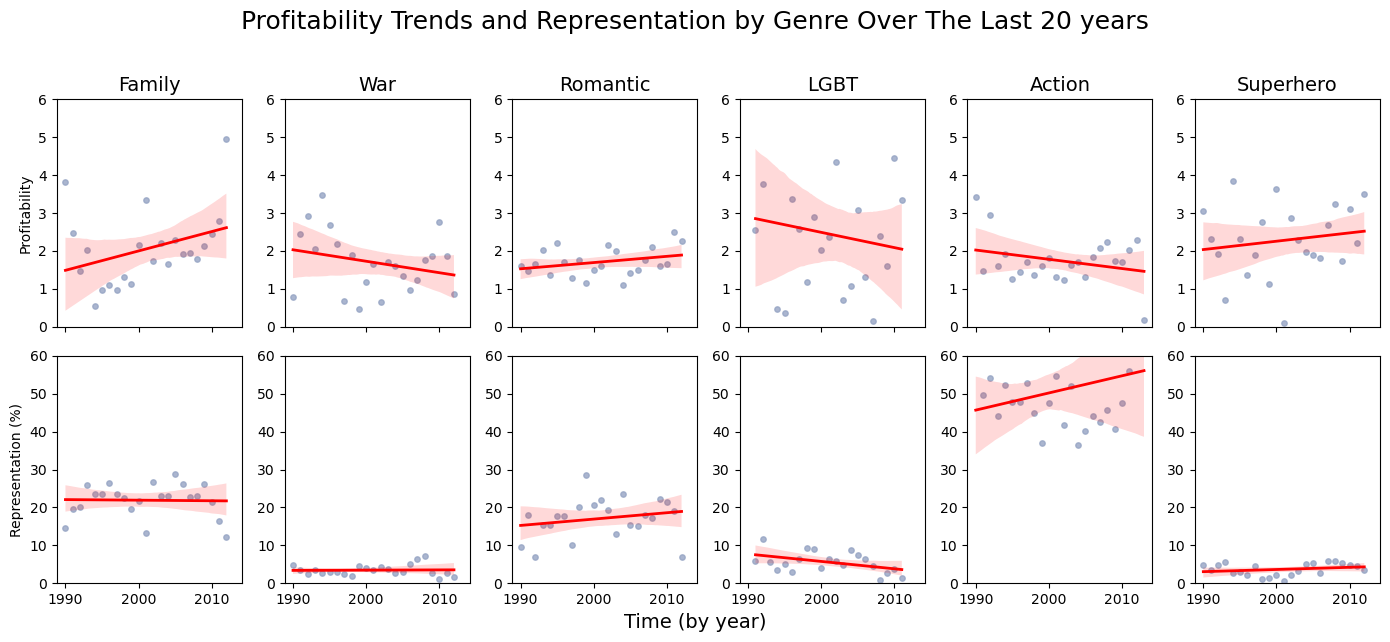

In [50]:
# Regression and scatterplot with 95% confidence interval which show how profitability evolved over the last 20 years, and how representation of movie genres 
# evolved over time for the last 20 years. 

#Plot grid creation
n_rows, n_cols = 2, 6
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 6), sharex=True, sharey=False)
axes = axes.flatten()

#Row 1 : profitability evolution over time for each studied genre
#Preparing data, keeping only data related to our genres and take the median profitability for each decade
df_genres_decade = df_exploded.groupby(['Movie release year', 'Movie genres'])['profitability'].median().reset_index()
df_genres_decade = df_genres_decade[df_genres_decade['Movie genres'].isin(genres_list)].reset_index(drop=True)
df_genres_decade = df_genres_decade[df_genres_decade['Movie release year'] > 1989]

#Plots with regression line and 95% confidence interval to observe trend
for i, theme in enumerate(genres_list):
    ax = axes[i]  
    theme_data = df_genres_decade[df_genres_decade['Movie genres'] == theme]
    sns.regplot(x='Movie release year', y='profitability', data=theme_data, ax=ax, color='#95a3c3', scatter_kws={'s': 15}, 
                line_kws={'color': 'red', 'linewidth': 2})
    ax.set_title(f"{theme}", fontsize=14)
    ax.set_ylim(0, 6)
    ax.set_xlabel("")
    ax.set_ylabel('Profitability')
    if i % n_cols != 0: 
        ax.set_ylabel("")



# Row 2: Percentage of each genre by decade to observe if it relates to the profitability trend
#Preparing data, keeping only data related to our genres and compute how much each genre is represented across all genres in %
df_genres_pct = df_exploded.groupby(['Movie release year', 'Movie genres']).size().reset_index(name='count')
df_genres_pct = df_genres_pct[df_genres_pct['Movie genres'].isin(genres_list)].reset_index(drop=True)
df_genres_pct = df_genres_pct[df_genres_pct['Movie release year'] > 1989]

df_genres_pct['total'] = df_genres_pct.groupby('Movie release year')['count'].transform('sum')
df_genres_pct['percentage'] = (df_genres_pct['count'] / df_genres_pct['total']) * 100

#Plots with regression line and 95% confidence interval to observe trend
for i, theme in enumerate(genres_list):
    ax = axes[1 * n_cols + i]  
    theme_data = df_genres_pct[df_genres_pct['Movie genres'] == theme]
    sns.regplot(x='Movie release year', y='percentage', data=theme_data, ax=ax, color='#95a3c3', scatter_kws={'s': 15}, 
        line_kws={'color': 'red', 'linewidth': 2})
    #ax.set_title(f"{theme}", fontsize=14)
    ax.set_ylim(0, 60)  
    ax.set_xlabel("")
    ax.set_ylabel('Representation (%)')
    if i % n_cols != 0:
        ax.set_ylabel("")

    
fig.suptitle("Profitability Trends and Representation by Genre Over The Last 20 years", fontsize=18, y=1.02)
plt.tight_layout()
fig.text(0.5, -0.01, "Time (by year)", ha='center', fontsize=14)
plt.show()

mpld3.save_html(fig, 'plot_6.html')

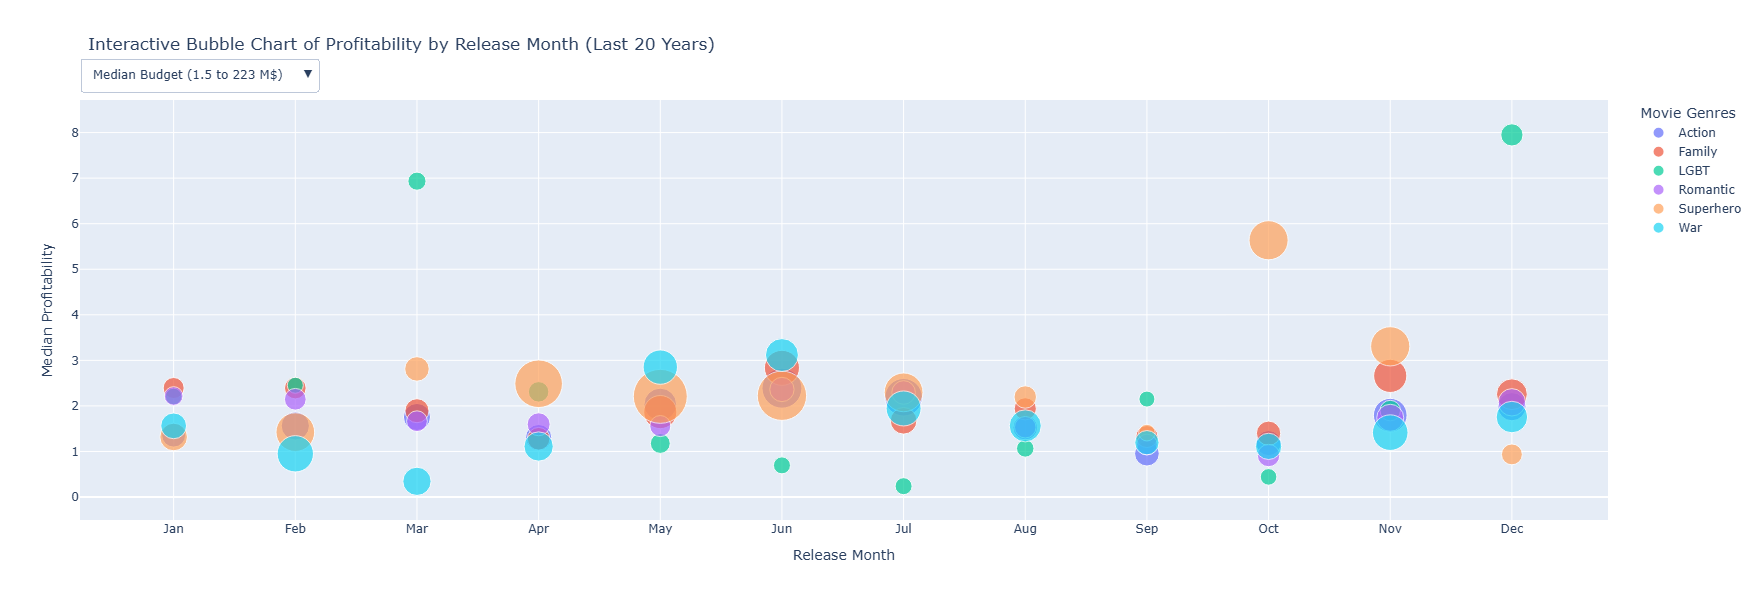

In [26]:
#Bubble chart representing the median profitability for each month for each movie genre. The bubble sizes represent median budget, sample count and median runtime. 

#Prepare data keeping only the last 20 years and genres we are interested in
df_bubbles = df_exploded.copy()  # Use your filtered dataset
df_bubbles = df_bubbles[df_bubbles['decade'] > 1989]  # Filter by decade
df_bubbles = df_bubbles[df_bubbles['Movie genres'].isin(genres_list)].reset_index(drop=True)

#Group by genre and month, and get the median profitability, budget, runtime and sample size.
df_aggregated = df_bubbles.groupby(['Movie genres', 'Movie release month']).agg(median_profitability=('profitability', 'median'), median_budget=('budget', 'median'),
    sample_size=('profitability', 'size'), median_runtime=('Movie runtime', 'median')).reset_index()

#For the display frmat hovering on bubbles only
df_aggregated['median_runtime_display'] = df_aggregated['median_runtime'].apply(lambda x: f"{x:.1f} min")
df_aggregated['median_budget_display'] = df_aggregated['median_budget'].apply(lambda x: f"${x / 1000000:.1f} M")

#Scale of the bubbles as we have 3 very different ranges (budget in millions, runtime in hunderds...)
def scale_sizes(values, min_size=8, max_size=27):
    min_val = np.min(values)
    max_val = np.max(values)
    if min_val == max_val:
        return np.full(len(values), (min_size + max_size) / 2)
    return min_size + (values - min_val) * ((max_size - min_size) / (max_val - min_val))

df_aggregated['runtime_scaled'] = scale_sizes(df_aggregated['median_runtime'])
df_aggregated['sample_scaled'] = scale_sizes(df_aggregated['sample_size'])
df_aggregated['budget_scaled'] = scale_sizes(df_aggregated['median_budget'])

#Creat figure
fig = px.scatter(df_aggregated, x="Movie release month", y="median_profitability", color="Movie genres", size="budget_scaled", hover_name="Movie genres", 
            hover_data={
        "sample_size": ":.0f",
        "median_budget_display": True,
        "median_runtime_display": True,
        "median_profitability": ":.1f",
        "Movie release month": True,
        "median_budget": False,
        "Movie genres": False,
        "budget_scaled": False
    },
    labels={
        "median_profitability": "Median Profitability",
        "median_budget_display": "Median Budget",
        "Movie release month": "Release Month",
        "median_runtime_display": "Median Runtime"
    },
    title="Interactive Bubble Chart of Profitability by Release Month (Last 20 Years)",
    width=900,
    height=600)

#Names for x axis (to replace numerical months
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
fig.update_xaxes(tickvals=list(range(1, 13)), ticktext=month_names[:12])

#Extract the ordered list of genres
trace_genres = [t.name for t in fig.data]

#For each genre, build marker size vectors to scale bubbles
ordered_budget_sizes = []
ordered_runtime_sizes = []
ordered_sample_sizes = []

for genre in trace_genres:
    subset = df_aggregated[df_aggregated['Movie genres'] == genre]
    subset = subset.sort_values(by='Movie release month')
    ordered_budget_sizes.append(subset['budget_scaled'].values)
    ordered_runtime_sizes.append(subset['runtime_scaled'].values)
    ordered_sample_sizes.append(subset['sample_scaled'].values)

#Create dropdown button with budget, runtime and sample size to change the bubble sizes accordingly
buttons = [
    dict(
        label="Median Budget (1.5 to 223 M$)",
        method="restyle",
        args=[{"marker.size": ordered_budget_sizes}]
    ),
    dict(
        label="Median Runtime (92 to 138 min)",
        method="restyle",
        args=[{"marker.size": ordered_runtime_sizes}]
    ),
    dict(
        label="Sample Size (3 to 182 samples)",
        method="restyle",
        args=[{"marker.size": ordered_sample_sizes}]
    )
]

fig.update_layout(
    legend_title="Movie Genres",
    updatemenus=[
        dict(
            type="dropdown",
            direction="down",
            showactive=True,
            x=0.0,
            xanchor="left",
            y=1.1,
            yanchor="top",
            buttons=buttons)])

fig.update_traces(marker=dict(sizemode='diameter', sizeref=0.5))
fig.show()
fig.write_html("plot.html")

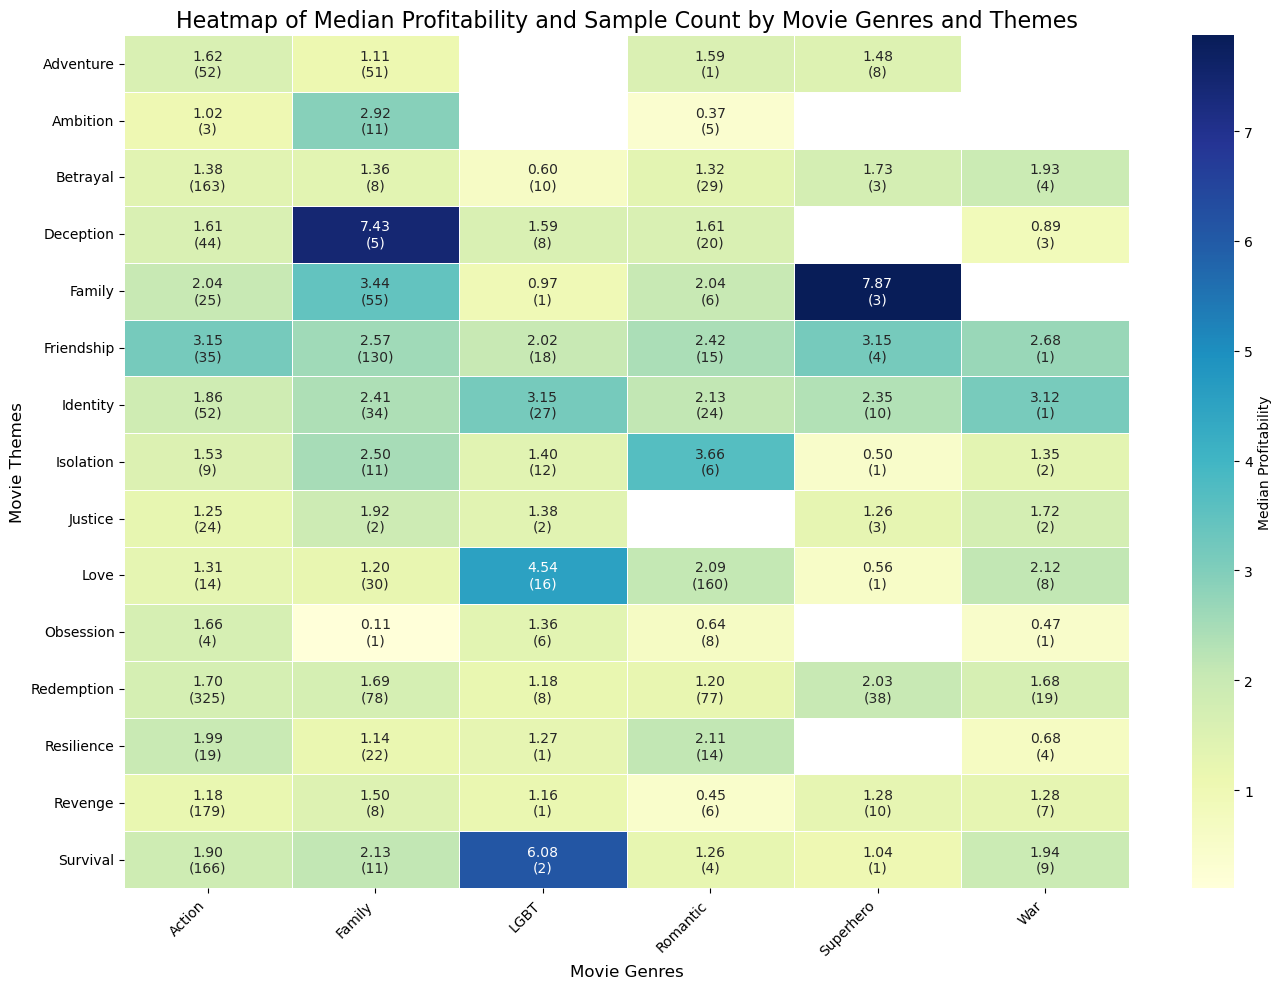

In [53]:
#Heatmap linking themes to genres, for profitability (including sample count between parenthesis)

#Prepare data of the last 20 years, keeping only the genres and themes we focus on
df_heatmap = df_exploded.copy()  
df_heatmap = df_heatmap[df_heatmap['decade'] > 1989] 
df_heatmap = df_heatmap[df_heatmap['Movie genres'].isin(genres_list)].reset_index(drop=True)
df_heatmap = df_heatmap[df_heatmap['Theme'].isin(top_10_themes.index)].reset_index(drop=True)

#Get the median profitability and sample size for each couple, organise it in a table
df_aggregated = df_heatmap.groupby(['Movie genres', 'Theme']).agg(median_profitability=('profitability', 'median'), 
        sample_size=('profitability', 'size')).reset_index()

df_heatmap_median = df_aggregated.pivot(index="Theme", columns="Movie genres", values="median_profitability")
df_heatmap_count = df_aggregated.pivot(index="Theme", columns="Movie genres", values="sample_size")

#Combine median profitability and sample count into a formatted str
annotations = pd.DataFrame("", index=df_heatmap_median.index, columns=df_heatmap_median.columns, dtype=object)
for row in annotations.index:
    for col in annotations.columns:
        median = df_heatmap_median.loc[row, col]
        count = df_heatmap_count.loc[row, col]
        if not pd.isna(median) and not pd.isna(count):
            annotations.loc[row, col] = f"{median:.2f}\n({int(count)})"

#Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df_heatmap_median, annot=annotations,  fmt="", cmap="YlGnBu",linewidths=0.5,cbar_kws={'label': 'Median Profitability'})

plt.title("Heatmap of Median Profitability and Sample Count by Movie Genres and Themes", fontsize=16)
plt.xlabel("Movie Genres", fontsize=12)
plt.ylabel("Movie Themes", fontsize=12)

plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

mpld3.save_html(fig, 'plot_8.html')